# Value at Risk (VAR) & Conditional Value at Risk (CVAR) Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime
from scipy.stats import norm


## Collect Sample Stock Data

In [2]:
# Define start and end date
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2023, 1, 1)
# Download stock data using yfinance, sample stock tickers: [AAPL (Apple), Meta, C (Citi group), DIS (Disney)]
df = yf.download(['AAPL','META', 'C', 'DIS'], start=start_date, end=end_date)['Adj Close']
df.index = pd.to_datetime(df.index)
df.head()

[*********************100%***********************]  4 of 4 completed


,AAPL,C,DIS,META
Date,,,,
2018-01-02,40.888062,62.809460,108.726059,181.419998
2018-01-03,40.880947,63.003731,109.192848,184.669998
2018-01-04,41.070835,63.780819,109.144241,184.330002
2018-01-05,41.538441,63.696362,108.551003,186.850006
2018-01-08,41.384151,62.953033,106.994995,188.279999


## Time-series plot

Text(0.5, 1.0, 'Adjusted Close Price for Sample Stock Tickers')

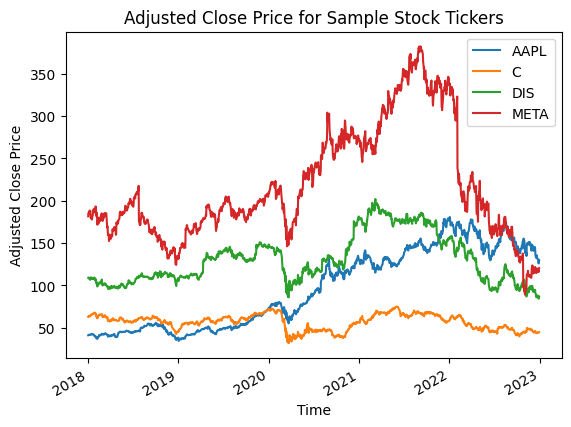

In [3]:
ax = df.plot.line(xlabel="Time", ylabel="Adjusted Close Price")
ax.set_title("Adjusted Close Price for Sample Stock Tickers")

## AAPL Percentage Change Histogram

Text(0.5, 1.0, 'Apple Percentage Change Histogram')

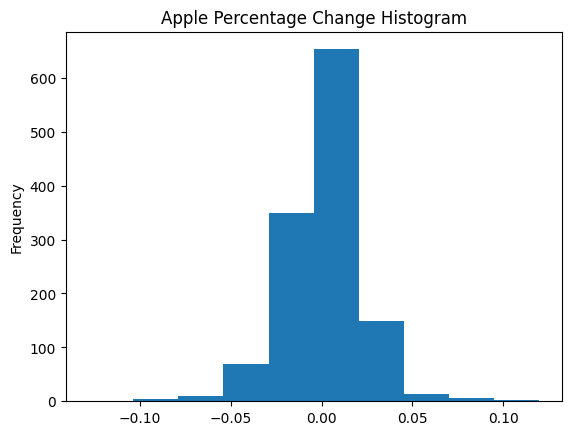

In [4]:
ax = df['AAPL'].pct_change().plot(kind='hist')
ax.set_title("Apple Percentage Change Histogram")

## 1. Historical Method

Assumption: **future** returns will follow a similar distribution to **historical** returns.

Therefore, no specific distribution for the portfolio returns.

In [5]:
# Obtain percentage change per stock
returns = df.pct_change()

# Calculate the portfolio returns as the weighted average of the individual asset returns
weights = np.full((4), 0.25) # assuming equal weight
port_returns = (weights * returns).sum(axis=1) # weighted sum

# Calculate the portfolio's VaR at 95% confidence level
confidence_level = 0.95
# Calculate P(Return <= VAR) = alpha
var = port_returns.quantile(q=1-confidence_level)

# Calculate CVAR by computing the average returns below the VAR level
cvar = port_returns[port_returns <= var].mean()

print(f"VaR at {confidence_level} confidence level: {var:.2%}")
print(f"CVaR at {confidence_level} confidence level: {cvar:.2%}")

VaR at 0.95 confidence level: -2.87%
CVaR at 0.95 confidence level: -4.40%


## 2. Parametric Method (Variance-Covariance)

Assumption 1: returns follow a **normal distribution**

Assumption 2: normality

Calculates VaR based on the z-score corresponding to the confidence level (95%)

Calculates CVAR based on the assumption of normality and the tail value at the VaR level.

### 2.1 Built from Scratch

In [6]:
# Obtain percentage change per stock
returns = df.pct_change()

# Calculate mean and covariance matrix of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Calculate portfolio mean return and standard deviation
weights = np.full((4), 0.25)
port_mean_return = (weights * mean_returns).sum()
port_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

# Calculate VaR and CVaR using the parametric method
confidence_level = 0.95
z_score = norm.ppf(q=1-confidence_level)
var = -1 * (port_mean_return - z_score * port_std_dev)
cvar = -1 * (port_mean_return - port_std_dev * (norm.pdf(z_score)/(1-confidence_level)))

print(f"VaR at {confidence_level} confidence level: {var:.2%}")
print(f"CVaR at {confidence_level} confidence level: {cvar:.2%}")

VaR at 0.95 confidence level: -3.04%
CVaR at 0.95 confidence level: 3.74%


Text(0.5, 1.0, 'Covariance Matrix of Returns')

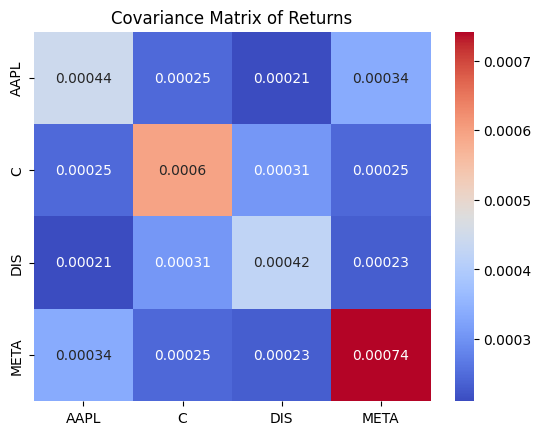

In [7]:
ax = sns.heatmap(cov_matrix, cmap='coolwarm', annot=True)
ax.set_title("Covariance Matrix of Returns")

### 2.2 Verification with [pypfopt](https://pyportfolioopt.readthedocs.io/en/latest/) Package

In [8]:
import datetime
import yfinance as yf
from pypfopt import risk_models, expected_returns
from scipy.stats import norm

# Calculate expected returns (mean) and sample covariance matrix
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Use CovarianceShrinkage to shrink and regularize the covariance matrix
S = risk_models.CovarianceShrinkage(df).ledoit_wolf()

# Define portfolio weights, assuming equal weight
weights = np.full((4), 0.25)

# Calculate portfolio mean and standard deviation (considering weighted sum)
portfolio_mean = (df.pct_change().dropna() * weights).sum(axis=1).mean()
portfolio_std = (df.pct_change().dropna() * weights).sum(axis=1).std()

# Calculate portfolio VaR and CVaR
alpha = 1 - confidence_level
z_alpha = norm.ppf(alpha)
portfolio_var = -1 * (portfolio_mean - z_alpha * portfolio_std)
portfolio_cvar = -1 * (portfolio_mean - (1 / alpha) * norm.pdf(z_alpha) * portfolio_std)

print(f"VaR at {confidence_level} confidence level: {portfolio_var:.2%}")
print(f"CVaR at {confidence_level} confidence level: {portfolio_cvar:.2%}")


VaR at 0.95 confidence level: -3.04%
CVaR at 0.95 confidence level: 3.74%


## 3. Monte Carlo Simulation

Assumption: future returns of the portfolio follow a **multivariate normal distribution**, which may not be true in reality

In [9]:
# Obtain daily returns
returns = df.pct_change()

# Calculate mean and covariance matrix of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Simulate future returns using Monte Carlo method
num_simulations = 100000
simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)

# Calculate simulated portfolio returns
weights = np.full((4), 0.25)
simulated_portfolio_returns = np.dot(simulated_returns, weights) # weighted sum

# Calculate VaR and CVaR using Monte Carlo method
confidence_level = 0.95
var = np.percentile(simulated_portfolio_returns, 100 - confidence_level * 100)
cvar = np.mean(simulated_portfolio_returns[simulated_portfolio_returns <= -var])

print(f"VaR at {confidence_level} confidence level: {var:.2%}")
print(f"CVaR at {confidence_level} confidence level: {cvar:.2%}")

VaR at 0.95 confidence level: -3.00%
CVaR at 0.95 confidence level: -0.19%


### Visualize Simulation Results

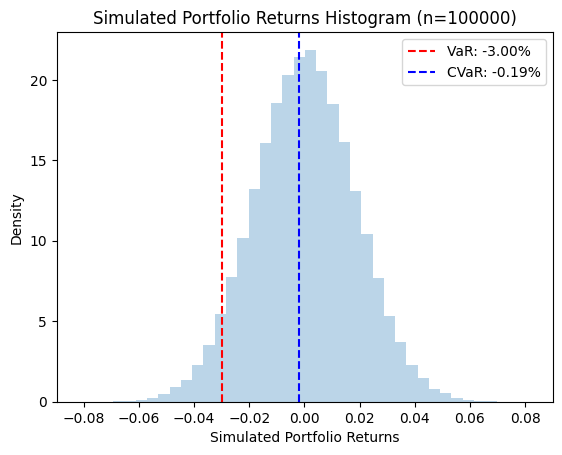

In [10]:
plt.hist(simulated_portfolio_returns, bins=40, density=True, alpha=0.3)

# Add VAR CVAR to the histogram
plt.axvline(x=var, color='red', linestyle='--', label=f"VaR: {var:.2%}")
plt.axvline(x=cvar, color='blue', linestyle='--', label=f"CVaR: {cvar:.2%}")

plt.legend()
plt.xlabel("Simulated Portfolio Returns")
plt.ylabel("Density")
plt.title(f"Simulated Portfolio Returns Histogram (n={num_simulations})")
plt.show()